In [1]:
import pandas as pd
import numpy as np
import cvxpy as cp

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#%cd 'drive/MyDrive/CEE 272R/Project'
%cd 'drive/MyDrive/Project'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1SKhA8FAOiV9pO2mZvZnMAzkXwvEPgBGZ/Project


### Load NEM 3.0 Rates and PG&E TOU Rates
For the NEM 3.0 rates, we are focusing on the ACC + Glide framework that encourages the implementation of solar + storage. We will use non-CARE prices to approximate total costs and gains for individuals with no extra government assistance on energy prices. We theroize that this is a larger majority of those utilizing NEM.

The TOU rate structure used for PG&E under NEM 3.0 is E-ELEC.

In [3]:
#TOU rates detail the price of electricty at any give point during the day
#Source: https://www.pge.com/tariffs/assets/pdf/tariffbook/ELEC_SCHEDS_E-ELEC.pdf
peak = 0.64328 #[$/kWh] 4-9pm
part_peak = 0.48140 #[$/kWh] 3-4pm, 9pm-12am
off_peak = 0.42472 #[$/kWh] all other hours
TOU_rates = np.empty(24, dtype=object)
TOU_rates[:14] = off_peak
TOU_rates[14:15] = part_peak
TOU_rates[15:21] = peak
TOU_rates[21:24] = part_peak
print(TOU_rates)
#NEM3 rates detail the price electric utilities will buy back production from individuals
#Source: https://docs.cpuc.ca.gov/PublishedDocs/Published/G000/M500/K043/500043682.PDF , section 8.5 "The Successor Tariff"
NEM3_rate = np.empty(24, dtype=object)
NEM3_rate[:] = 0.022 #[$/kWh] -> Sell back to grid price!
print(NEM3_rate)

[0.42472 0.42472 0.42472 0.42472 0.42472 0.42472 0.42472 0.42472 0.42472
 0.42472 0.42472 0.42472 0.42472 0.42472 0.4814 0.64328 0.64328 0.64328
 0.64328 0.64328 0.64328 0.4814 0.4814 0.4814]
[0.022 0.022 0.022 0.022 0.022 0.022 0.022 0.022 0.022 0.022 0.022 0.022
 0.022 0.022 0.022 0.022 0.022 0.022 0.022 0.022 0.022 0.022 0.022 0.022]


### Load Average Hourly Solar Irradiances

In [4]:
solar_df = pd.read_csv('Project Data/141409_37.41_-122.14_tmy-2022.csv', header=2)

jun_irradiance = solar_df.loc[solar_df['Month'] == 6][['Hour', 'DNI']]
sep_irradiance = solar_df.loc[solar_df['Month'] == 9][['Hour', 'DNI']]
dec_irradiance = solar_df.loc[solar_df['Month'] == 12][['Hour', 'DNI']]
mar_irradiance = solar_df.loc[solar_df['Month'] == 3][['Hour', 'DNI']]

jun_IR = jun_irradiance.groupby('Hour').mean().to_numpy()/1000
sep_IR = sep_irradiance.groupby('Hour').mean().to_numpy()/1000
dec_IR = dec_irradiance.groupby('Hour').mean().to_numpy()/1000
mar_IR = mar_irradiance.groupby('Hour').mean().to_numpy()/1000

print(jun_IR) #All values in kW/m^2
print()
print(sep_IR)
print()
print(dec_IR)
print()
print(mar_IR)

[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.24463333]
 [0.5142    ]
 [0.56463333]
 [0.6716    ]
 [0.72563333]
 [0.78623333]
 [0.79576667]
 [0.80783333]
 [0.81353333]
 [0.83043333]
 [0.78746667]
 [0.70323333]
 [0.6131    ]
 [0.41196667]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]

[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.35333333]
 [0.45566667]
 [0.5558    ]
 [0.76516667]
 [0.783     ]
 [0.81016667]
 [0.87016667]
 [0.8438    ]
 [0.82576667]
 [0.79053333]
 [0.65386667]
 [0.39703333]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]

[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.03545161]
 [0.35948387]
 [0.40083871]
 [0.46370968]
 [0.49925806]
 [0.50329032]
 [0.48316129]
 [0.41777419]
 [0.3766129 ]
 [0.13325806]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [

### Load Average Hourly Demands

In [5]:
# Load average hourly demand from 2019 to 2023
load = pd.read_csv('Project Data/e1_dynamic_2001.csv', parse_dates=['Date'])
load = load.loc[((load['Date'].dt.year >= 2019) & (load['Date'].dt.year <= 2023))] # only data between 2019 and 2023

# June
jun_load = load.loc[(load['Date'].dt.month == 6)]
jun_load = jun_load.drop(columns=['Profile', 'Date'])
jun_load = jun_load.astype(float)
jun_load = jun_load.mean(axis=0).values
jun_load = np.insert(jun_load, 0, jun_load[23])
jun_load = np.delete(jun_load, 24)
jun_load = np.reshape(jun_load, (24, 1))

# September
sep_load = load.loc[(load['Date'].dt.month == 9)]
sep_load = sep_load.drop(columns=['Profile', 'Date'])
sep_load = sep_load.astype(float)
sep_load = sep_load.mean(axis=0).values
sep_load = np.insert(sep_load, 0, sep_load[23])
sep_load = np.delete(sep_load, 24)
sep_load = np.reshape(sep_load, (24, 1))

# December
dec_load = load.loc[(load['Date'].dt.month == 12)]
dec_load = dec_load.drop(columns=['Profile', 'Date'])
dec_load = dec_load.astype(float)
dec_load = dec_load.mean(axis=0).values
dec_load = np.insert(dec_load, 0, dec_load[23])
dec_load = np.delete(dec_load, 24)
dec_load = np.reshape(dec_load, (24, 1))

# March
mar_load = load.loc[(load['Date'].dt.month == 3)]
mar_load = mar_load.drop(columns=['Profile', 'Date'])
mar_load = mar_load.astype(float)
mar_load = mar_load.mean(axis=0).values
mar_load = np.insert(mar_load, 0, mar_load[23])
mar_load = np.delete(mar_load, 24)
mar_load = np.reshape(mar_load, (24, 1))

print(jun_load)
print()
print(sep_load)
print()
print(dec_load)
print()
print(mar_load)

<ipython-input-5-293b864e6a19>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  load = pd.read_csv('Project Data/e1_dynamic_2001.csv', parse_dates=['Date'])


[[0.85719033]
 [0.74420833]
 [0.665004  ]
 [0.60688967]
 [0.56928   ]
 [0.55507   ]
 [0.558505  ]
 [0.57051467]
 [0.58897233]
 [0.606628  ]
 [0.63186533]
 [0.667983  ]
 [0.713879  ]
 [0.77075   ]
 [0.82561567]
 [0.88225333]
 [0.950798  ]
 [1.02979933]
 [1.11986833]
 [1.18529567]
 [1.188946  ]
 [1.16043033]
 [1.12580067]
 [1.002412  ]]

[[0.81475733]
 [0.72903333]
 [0.657175  ]
 [0.603892  ]
 [0.57124333]
 [0.558511  ]
 [0.5651    ]
 [0.59896833]
 [0.628038  ]
 [0.617313  ]
 [0.62154333]
 [0.63768033]
 [0.67109333]
 [0.722681  ]
 [0.776462  ]
 [0.83984833]
 [0.92322367]
 [1.020453  ]
 [1.121114  ]
 [1.17615067]
 [1.18130233]
 [1.14224933]
 [1.063327  ]
 [0.94027967]]

[[0.78916484]
 [0.71769065]
 [0.66186774]
 [0.62660355]
 [0.60895774]
 [0.61347484]
 [0.65119032]
 [0.71939645]
 [0.79454161]
 [0.80601548]
 [0.78938097]
 [0.76992839]
 [0.75296161]
 [0.73958323]
 [0.72467   ]
 [0.72661548]
 [0.76404613]
 [0.87170097]
 [1.03148645]
 [1.08526903]
 [1.07493484]
 [1.04652806]
 [0.9912171 ]
 [

### 1-Day Model
Optimize the total cost given a single solar panel and single power wall installed. Optimization is to minimize cost and maximize power sold to the grid. This will minimize net total cost.

In [12]:
#Size of a single SunPower panel: SPR-X21-345 (https://provisionsolar.com/wp-content/uploads/2014/12/SunPower-X21-345-COM-Data-Sheet.pdf)
SINGLE_PANEL_SIZE = 3.43*5.11 #[ft^2]
DELTA_t = 1 #[hr]                                       Interval between timestamps
TIMESTEPS = 24 #[hr]                                    Total number of timestamps, hours
M =  10e6 #[unitsless]                                  Large upper bound number
MIN_SOC = 0
MAX_SOC = 1
INITIAL_SOC = 0.5
FINAL_SOC = 0.5

#Cost Heatmap generated through iterative optimizations
daily_cost_map = []
# Generate a different heat map for each of the 4 months
for k, m in enumerate([3, 6, 9, 12]):
  month_map = []

  if m == 6:
    ir = jun_IR
    load = jun_load
  elif m == 9:
    ir = sep_IR
    load = sep_load
  elif m == 12:
    ir = dec_IR
    load = dec_load
  else:
    ir = mar_IR
    load = mar_load

  #Only allows 0-4 Tesla Powerwalls to be installed together
  for pw in range(5):
    power_wall_row = []
    #Assume a maximum of around 40 solar panels atop a single roof
    for sp in range(41):
      ENERGY_CAPACITY = 13.5 * pw #[kWh * # = kWh]            (13.5 is a single powerwall 3)
      MAX_DISCHARGE_RATE = 11.5 * pw #[kW * # = kW]           (from powerwall 3 specs)
      MAX_CHARGE_RATE = 5 * pw #[kW * # = kW]                 (from powerwall 3 specs)

      #Neither include installation or O+M costs, as well as state credits/discounts
      daily_storage_price = 11500*pw/(10*365) #[$*powerwall/powerwall*day = $/day]
      daily_solar_price = sp*SINGLE_PANEL_SIZE*19.7*3.75/(10*365)   #[# panels * ft^2 * W/ft^2 * $/W * 1/day = $/day]

      #VARIABLES
      Batt_output = cp.Variable((TIMESTEPS, 1), name='Batt_output') #[kW]
      SOC_batt = cp.Variable((TIMESTEPS + 1, 1), name='SOC_batt')
      smr = cp.Variable((TIMESTEPS, 1), name='smr')
      Buy = cp.Variable((TIMESTEPS, 1), name='Buy')
      Sell = cp.Variable((TIMESTEPS, 1), name='Sell')
      b_Buy = cp.Variable((TIMESTEPS, 1), name='Binary Buy', boolean = True)
      b_Sell = cp.Variable((TIMESTEPS, 1), name='Binary Sell', boolean = True)

      #OBJECTIVE
      obj = Buy.T @ TOU_rates - Sell.T @ NEM3_rate + daily_storage_price + daily_solar_price + (145/365) #145 is the interconnection fee applicable to NEM 3.0 and NEM 2.0

      #CONSTRAINTS
      constraints = [
      smr == load - Batt_output - (ir*sp*.215), #[kW - (kW/m^2*m^2) = kW]        Multiplying by .25 for solar panel efficiency
      smr == Buy - Sell,
      Buy >= 0,
      Sell >= 0,
      b_Buy + b_Sell <= 1,
      Buy <= b_Buy*M,
      Sell <= b_Sell*M,
      Batt_output <= MAX_DISCHARGE_RATE, #[kW]
      Batt_output >= -MAX_CHARGE_RATE, #[kW]
      SOC_batt >= MIN_SOC, #unitless
      SOC_batt <= MAX_SOC, #unitless
      SOC_batt[0] == INITIAL_SOC, #unitless
      SOC_batt[-1] == FINAL_SOC, #unitless
      ]

      for i in range(0, SOC_batt.size - 1):
          constraints += [SOC_batt[i+1] == SOC_batt[i] - (Batt_output[i]/(ENERGY_CAPACITY/DELTA_t))] #unitless

      #solve the CVX problem
      prob = cp.Problem(cp.Minimize(obj), constraints)
      total_cost = prob.solve(solver=cp.ECOS_BB)

      #Add to matrix row
      power_wall_row.append(total_cost)

    #Add to row to matrix
    month_map.append(power_wall_row)
  daily_cost_map.append(month_map)

### Plotting

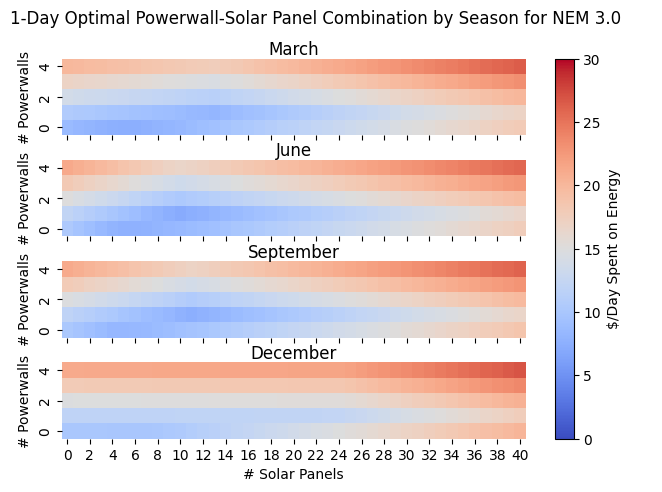

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.cm as cm

norm = mcolors.Normalize(0, 30)

# Heatmaps 3, 6, 9, 12
fig, axn = plt.subplots(4, 1, sharex=True, sharey=True)
for i, ax in enumerate(axn.flat):
    sns.heatmap(daily_cost_map[i], ax=ax,
                norm=norm, cbar=False, cmap='coolwarm')
    axn[i].invert_yaxis()
    axn[i].set_ylabel('# Powerwalls')
fig.suptitle("1-Day Optimal Powerwall-Solar Panel Combination by Season for NEM 3.0      ", ha='center', va='center')
axn[0].set_title("March", ha='center', va='center')
axn[1].set_title("June", ha='center', va='center')
axn[2].set_title("September", ha='center', va='center')
axn[3].set_title("December", ha='center', va='center')
ax.set_xlabel('# Solar Panels')
fig.tight_layout(pad=0.5)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap='coolwarm'), ax=axn, label="$/Day Spent on Energy")

### Optimized Values by Season

In [14]:
char = min(x if isinstance(x, int) else min(x) for x in daily_cost_map[0])
def find_in_list_of_list(mylist, char):
    for sub_list in mylist:
        if char in sub_list:
            return (mylist.index(sub_list), sub_list.index(char))
    raise ValueError("'{char}' is not in list".format(char = char))

index = find_in_list_of_list(daily_cost_map[0], char)
print("The optimized number of powerwalls for March is", index[0])
print("The optimized number of solar panels for March is", index[1])
print("The daily price of energy is", char)

The optimized number of powerwalls for March is 0
The optimized number of solar panels for March is 5
The daily price of energy is 7.385154859772014


In [15]:
char = min(x if isinstance(x, int) else min(x) for x in daily_cost_map[1])
def find_in_list_of_list(mylist, char):
    for sub_list in mylist:
        if char in sub_list:
            return (mylist.index(sub_list), sub_list.index(char))
    raise ValueError("'{char}' is not in list".format(char = char))

index = find_in_list_of_list(daily_cost_map[1], char)
print("The optimized number of powerwalls for June is", index[0])
print("The optimized number of solar panels for June is", index[1])
print("The daily price of energy is", char)

The optimized number of powerwalls for June is 1
The optimized number of solar panels for June is 10
The daily price of energy is 7.087654193404382


In [16]:
char = min(x if isinstance(x, int) else min(x) for x in daily_cost_map[2])
def find_in_list_of_list(mylist, char):
    for sub_list in mylist:
        if char in sub_list:
            return (mylist.index(sub_list), sub_list.index(char))
    raise ValueError("'{char}' is not in list".format(char = char))

index = find_in_list_of_list(daily_cost_map[2], char)
print("The optimized number of powerwalls for September is", index[0])
print("The optimized number of solar panels for September is", index[1])
print("The daily price of energy is", char)

The optimized number of powerwalls for September is 1
The optimized number of solar panels for September is 11
The daily price of energy is 7.4564434955176475


In [17]:
char = min(x if isinstance(x, int) else min(x) for x in daily_cost_map[3])
def find_in_list_of_list(mylist, char):
    for sub_list in mylist:
        if char in sub_list:
            return (mylist.index(sub_list), sub_list.index(char))
    raise ValueError("'{char}' is not in list".format(char = char))

index = find_in_list_of_list(daily_cost_map[3], char)
print("The optimized number of powerwalls for December is", index[0])
print("The optimized number of solar panels for December is", index[1])
print("The daily price of energy is", char)

The optimized number of powerwalls for December is 0
The optimized number of solar panels for December is 7
The daily price of energy is 9.92863860133272
